# Breast Cancer Wisconsin

### 1) Context
Streamlining workflows using pipeline!

### 2) Requirements

In [196]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### 3) Data Imports and pre-processing
**Imports**

In [2]:
df= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**Segreation of ID, y, X**

In [155]:
#Segregating data into ID, y, X
ID=df.iloc[:, 0]
y=df.iloc[:, 1]
X=df.iloc[:, 2:]

**Preprocessing target y variable**
Doing it here itself as pipeline would expect onnly X in transformers

In [156]:
le=LabelEncoder()
y=le.fit_transform(y)
pd.Series(y).value_counts()

0    357
1    212
dtype: int64

**Splitting data into train-test (based on y strata) to keep test aside for testing**

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

### 4) Building baseline model by creating a pipeline of transformers and estimators
Note: Pipeline is such that transformers must be for X only, and any transformation for y must be done spearately

In [158]:
#Baseline model using pipeline
pipe_lr=make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     LogisticRegression(random_state=123, solver='lbfgs'))
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=123))])

Assessing and getting an idea about model performance using Hold-out validation

In [159]:
#Directly testing on unseen data without any validation - could be over or under promising
y_pred = pipe_lr.predict(X_test)
print('Test accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test accuracy: 0.956


### 5) Assessing baseline model performance using K-Fold validation
Calculating Cross-val-score. We'll get a lower variance in performance estimate as compared to holdout validation

In [183]:
#Using manually controlled Stratified kFolds
SKF=StratifiedKFold(n_splits=10)
pipe_lr_scores=[]
for k, (train_id, valid_id) in enumerate(SKF.split(X_train, y_train)):
    pipe_lr.fit(X_train.iloc[train_id], y_train[train_id])
    pipe_lr_score=pipe_lr.score(X_train.iloc[valid_id], y_train[valid_id])
    pipe_lr_scores.append(pipe_lr_score)
    print(k, 'Test accuracy: %.3f'% pipe_lr_score)

print('\n(Avg +/- Std) for scores is (%.3f +/- %.3f)' % (np.mean(pipe_lr_scores), np.std(pipe_lr_scores)))

0 Test accuracy: 0.935
1 Test accuracy: 0.935
2 Test accuracy: 0.957
3 Test accuracy: 0.935
4 Test accuracy: 0.935
5 Test accuracy: 1.000
6 Test accuracy: 0.956
7 Test accuracy: 0.978
8 Test accuracy: 0.933
9 Test accuracy: 0.933

(Avg +/- Std) for scores is (0.950 +/- 0.022)


In [195]:
#Using direct function 
pipe_lr_scores=cross_val_score(pipe_lr,
                      X_train,
                      y_train,
                      cv=10,
                      n_jobs=1)
print(pipe_lr_scores)
print('\n(Avg +/- Std) for scores is (%.3f +/- %.3f)' % (np.mean(pipe_lr_scores), np.std(pipe_lr_scores)))

[0.93478261 0.93478261 0.95652174 0.93478261 0.93478261 1.
 0.95555556 0.97777778 0.93333333 0.93333333]

(Avg +/- Std) for scores is (0.950 +/- 0.022)


### 6) Debugging model using learning and validation curves ###
Learning curve - to understand and diagnose bias/variance problems 
    
    - checking how train/valid performance growing with data
    - checking performance for train/valid w.r.t. desired 80% line
    - checking how far are train/valid performance from each other

In [204]:
train_sizes, train_score, valid_score = learning_curve(pipe_lr,
                                                      X=X_train,
                                                      y=y_train,
                                                      train_sizes=np.linspace(0.1,1,10),
                                                      cv=10)

In [210]:
train_mean = np.mean(train_score, axis=1)
train_std = np.std(train_score, axis=1)
valid_mean = np.mean(valid_score, axis=1)
valid_std = np.std(valid_score, axis=1)

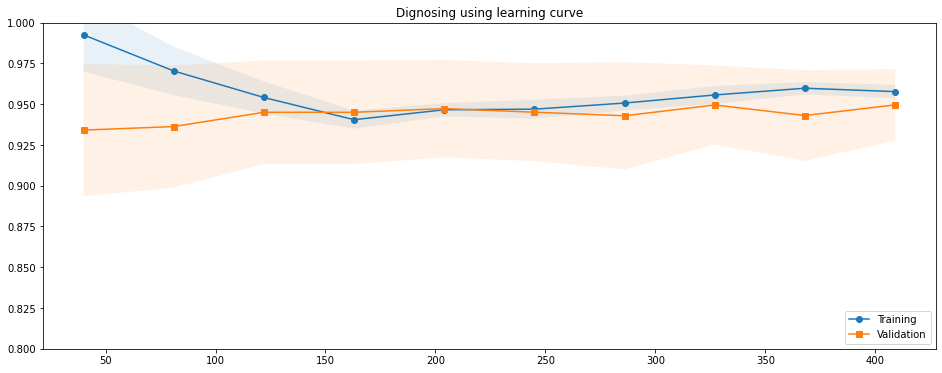

In [230]:
plt.figure(figsize=(16,6))
plt.plot(train_sizes, train_mean, marker='o', label='Training')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.1)
plt.plot(train_sizes, valid_mean, marker='s', label='Validation')
plt.fill_between(train_sizes, valid_mean+valid_std, valid_mean-valid_std, alpha=0.1)
plt.ylim([0.8, 1.0])
plt.title('Dignosing using learning curve')
plt.legend(loc='lower right')
plt.show()